In [1]:
import csv
import time
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from verstack.stratified_continuous_split import scsplit # pip install verstack
from nltk.corpus import stopwords 

import torch
import torch.nn.functional as F

from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import os
import gensim
from gensim.models.doc2vec import Doc2Vec
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

### 基本思路
使用如下两组要素
- 数字变量
  1. favorites count (log_stand)
  2. followers count (log_stand)
  3. statues count (发推数量) (log_stand)
  4. friends count (log_stand)
  5. urls count (log_stand)
  6. verified (1 or 0) (这一部分我们不做log_stand)
  7. timestamp (一天内的早中晚（hour），距离大选的时间(month和day)，周几(wday)都可能产生影响)
- 文本变量
  1. tweet text
  2. hashtags 

将文本变量通过embedding处理后用CNN/LSTM得到一部分输出，另外对数字变量通过CNN也得到了一部分结果，最后汇总，用2层dense layer。


In [2]:
# Load data

train_data = pd.read_csv("data/train.csv")
eval_data = pd.read_csv("data/evaluation.csv")

# Pre-process the traning data
label = "text"
train_data[label] = train_data[label].map(lambda x: str.split(x, sep=" "))


label = "mentions"
train_data[label+"_count"] = train_data[label].map(lambda x: len(str.split(x)))
mentions = set()
train_data[label].apply(lambda x: mentions.update(x))
print("all mentions in train data: ", mentions)


label = "urls"
train_data[label] = train_data[label].map(lambda x: [] if x=="[]" else [str.strip(url) for url in str.split(x[1:-1], sep=",")])
train_data[label+"_count"] = train_data[label].map(lambda x: len(x))
urls = set()
# hashtags=set()
train_data[label].apply(lambda x: None if len(x)<1 else urls.update(x))
# train_data[label].apply(lambda x: None if len(x)<1 else hashtags.update(x))
print(f"average number of urls in train data: {train_data.urls_count.mean():1.3f}")
print("number of distinct urls in train data: ", len(urls))

label = "verified"
print("verified users: ", train_data["verified"].sum())


label = "hashtags"
train_data[label] = train_data[label].map(lambda x: [] if x=="[]" else [str.strip(tag) for tag in str.split(x[1:-1], sep=",")])
train_data[label+"_count"] = train_data[label].map(lambda x: len(x))
hashtags = set()
train_data[label].apply(lambda x: None if len(x)<1 else hashtags.update(x))
print(f"average number of hashtags in train data: {train_data.hashtags_count.mean():1.3f}")
print("number of distinct hashtags in train data:", len(hashtags))


label = "hashtags"
eval_data[label] = eval_data[label].map(lambda x: [] if x=="[]" else [str.strip(tag) for tag in str.split(x[1:-1], sep=",")])
eval_data[label+"_count"] = eval_data[label].map(lambda x: len(x))
hashtags2 = set()
eval_data[label].apply(lambda x: None if not x else hashtags2.update(x))
print(f"average number of hashtags in evaluation data: {eval_data.hashtags_count.mean():1.3f}")
print("number of distinct hashtags in evaluation data:", len(hashtags2))



# Treatment of time
# The time relative to the election (month and yday), day in the week, 
# and the hour all affect the number of retweets.
train_data["timestamp"] = train_data["timestamp"].map(lambda x: time.gmtime(x//1000))
# Only 2380 tweets are not posted in 2022, so we ignore the year
# train_data["year"] = train_data["timestamp"].map(lambda x: x.tm_year)
train_data["month"] = train_data["timestamp"].map(lambda x: x.tm_mon)
train_data["yday"] = train_data["timestamp"].map(lambda x: x.tm_yday)
train_data["wday"] = train_data["timestamp"].map(lambda x: x.tm_wday)
train_data["hour"] = train_data["timestamp"].map(lambda x: x.tm_hour)
print("number of tweets not posted in 2022 in train data:", len(train_data[train_data["timestamp"].map(lambda x: x.tm_year) < 2022]))

# We drop the following data:
# @TweetID: useless
# @mentions: none of the mentions in the train data are not null
# @mentions_count
# @hashtags_count: we use hashtags directly
# @urls: we use urls_count instead

train_data.drop(labels=["TweetID","timestamp", "mentions","mentions_count", "hashtags_count", "urls"], axis=1, inplace=True)
train_data.head(5)

all mentions in train data:  {']', '['}
average number of urls in train data: 0.529
number of distinct urls in train data:  185951
verified users:  10621
average number of hashtags in train data: 0.297
number of distinct hashtags in train data: 12093
average number of hashtags in evaluation data: 0.299
number of distinct hashtags in evaluation data: 5942
number of tweets not posted in 2022 in train data: 2380


,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,verified,hashtags,urls_count,month,yday,wday,hour
0,"[rt, refarcir, macron, ans, nom, prépare]",3,0,3682,453535,3628,0,[],0,3,70,4,5
1,[populaire],0,0,86,1016,284,0,[],0,3,78,5,12
2,"[faut, dégager, cinglé]",3,1,1944,28234,1995,0,[],0,3,74,1,18
3,"[enseignants, mettre, prescriptions, président...",0,0,1,1072,0,0,[],1,3,73,0,11
4,"[mafieuse, oppressive, macron]",0,0,13957,25311,10841,0,[],0,3,73,0,11


In [3]:
# Here we split our training data into trainig and testing set. This way we can estimate the evaluation of our model without uploading to Kaggle and avoid overfitting over our evaluation dataset.
# scsplit method is used in order to split our regression data in a stratisfied way and keep a similar distribution of retweet counts between the two sets
X_train, X_test, y_train, y_test = scsplit(train_data, train_data['retweets_count'], stratify=train_data['retweets_count'], train_size=0.7, test_size=0.3)

# We remove the actual number of retweets from our features since it is the value that we are trying to predict
X_train = X_train.drop(["retweets_count"], axis=1)
X_test = X_test.drop(["retweets_count"], axis=1)

# log transform
def log_transform(data, list_column):
        for name_column in list_column:
            data[name_column] = np.log(data[name_column])

# standardise the columns of numeric values
def standardise(data,list_column):
    for name_column in list_column:
        # standardize
        if data[name_column].std()!=0:
            data[name_column]=(data[name_column]-data[name_column].mean())/data[name_column].std()
        else:
            data[name_column]=(data[name_column]-data[name_column].mean())

standardise(X_train,["favorites_count","followers_count","statuses_count","friends_count","urls_count","month","yday","wday","hour"])
standardise(X_test, ["favorites_count","followers_count","statuses_count","friends_count","urls_count","month","yday","wday","hour"])

standardise(X_train,["favorites_count","followers_count","statuses_count","friends_count","urls_count","month","yday","wday","hour"])
standardise(X_test, ["favorites_count","followers_count","statuses_count","friends_count","urls_count","month","yday","wday","hour"])

# split the table into 2 parts: one with the text and the other with the numbers
X_train_num=X_train.drop(["text", "hashtags"], axis=1)
X_test_num=X_test.drop(["text", "hashtags"], axis=1)

X_train_text=X_train[["text", "hashtags"]]
X_test_text=X_test[["text", "hashtags"]]

In [4]:
# This part is used to train the embedding of the vocabulary, only needed to be run once

path_text_dataset='French-Word-Embeddings/Data/data.txt'
text_dataset=pd.read_table(path_text_dataset).values
text_dataset=[item[0][:-1] for item in text_dataset]

TaggedDocument=gensim.models.doc2vec.TaggedDocument

def X_text(sentences):
    X=[]
    for i,text in enumerate(sentences):
        words=text.split(" ")
        l=len(words)
        words=words[:-2]
        document=TaggedDocument(words,tags=[i])
        X.append(document)
    return X

X_documents=X_text(text_dataset)
X_documents[:5]

def train_text(text_train,size=10,epochs=10):
    model=Doc2Vec(text_train,min_count=1,window=3,vector_size=size,sample=1e-3,negative=5,epochs=epochs)
    model.train(text_train,total_examples=model.corpus_count,epochs=model.epochs)
    return model

if not os.path.exists('./WE_models'):
    os.mkdir('./WE_models')

# run only once this part  
# model_text10=train_text(X_documents, size=64)
# model_text10.save('WE_models/d2v_64D')
# model_text5=train_text(X_documents, size=32)
# model_text5.save('WE_models/d2v_32D')

In [11]:
# Here we load the embedding model:
model_text10 = Doc2Vec.load('WE_models/d2v_10D')
model_text5 = Doc2Vec.load('WE_models/d2v_5D')

In [12]:
# Tranform the textual part to vector

def text2vec(text_train, model, alpha=0.05, min_alpha=0.025, epochs=10, tags=True):
    list_text=[]
    for sentence in text_train:
        vec = model.infer_vector(doc_words=sentence, alpha=alpha, min_alpha=min_alpha, epochs=epochs).tolist()
        list_text.append(vec)
    return np.array(list_text)

# text to vector
train_text_tensor=torch.Tensor(text2vec(X_train_text["text"], model=model_text10))
test_text_tensor=torch.Tensor(text2vec(X_test_text["text"], model=model_text10))

# hashtags to vector
train_tags_tensor=torch.Tensor(text2vec(X_train_text["hashtags"], model=model_text5))
test_tags_tensor=torch.Tensor(text2vec(X_test_text["hashtags"], model=model_text5))

# combine the two vectors
X_train_text_tensor = torch.cat((train_text_tensor, train_tags_tensor), axis=1)
X_test_text_tensor = torch.cat((test_text_tensor, test_tags_tensor), axis=1)


In [13]:
X_train_num_vec=X_train_num.to_numpy()
X_train_text_vec=X_train_text_tensor.numpy()
X_train_vec=np.hstack([X_train_num_vec,X_train_text_vec])

X_test_num_vec=X_test_num.to_numpy()
X_test_text_vec=X_test_text_tensor.numpy()
X_test_vec=np.hstack([X_test_num_vec,X_test_text_vec])

y_train_vec=y_train.to_numpy()
y_test_vec=y_test.to_numpy()

In [14]:
X_train_num_tensor=torch.Tensor(X_train_num.values)
X_test_num_tensor=torch.Tensor(X_test_num.values)

X_train_tensor=torch.cat((X_train_num_tensor, X_train_text_tensor), axis=1)
X_test_tensor=torch.cat((X_test_num_tensor, X_test_text_tensor), axis=1)

y_train_tensor=torch.Tensor(y_train.to_numpy()).reshape((-1,1))
y_test_tensor=torch.Tensor(y_test.to_numpy()).reshape((-1,1))

print(X_train_num_tensor.shape, y_train_tensor.shape)
print(X_train_text_tensor.shape, X_test_text_tensor.shape)
print(X_train_tensor.shape, X_test_tensor.shape)

torch.Size([247778, 10]) torch.Size([247778, 1])
torch.Size([247778, 15]) torch.Size([106191, 15])
torch.Size([247778, 25]) torch.Size([106191, 25])


In [15]:
def MAE(pred,real):
    N=len(pred)
    sum=0
    for i in range(N):
        sum+=abs(pred[i]-real[i])
    return sum/N

In [16]:
def model_result(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_pred = np.array([int(value) if value >= 0 else 0 for value in y_pred])
    loss=MAE(y_pred,y_test)
    return loss

In [47]:
model_LR=LinearRegression()

In [48]:
loss_LR=model_result(model_LR,X_train_vec,y_train_vec,X_test_vec,y_test_vec)
loss_LR

11.873445018881073

In [49]:
loss_LR_num=model_result(model_LR,X_train_num_vec,y_train_vec,X_test_num_vec,y_test_vec)
loss_LR_num

11.778079121582808

In [39]:
Lasso_alpha_list=[0.1*i for i in range(0,15)]
loss_Lasso_tot=[]
for alpha in Lasso_alpha_list:    
    # print(alpha)
    model_Lasso=Lasso(alpha=alpha)
    loss_Lasso=model_result(model_Lasso,X_train_vec,y_train_vec,X_test_vec,y_test_vec)
    print("loss="+str(loss_Lasso)+"; param={:2f}".format(alpha))
    loss_Lasso_tot.append(loss_Lasso)

loss=11.873445018881073; param=0.000000
loss=11.791018071211308; param=0.100000
loss=11.75600568786432; param=0.200000
loss=11.733593242365172; param=0.300000
loss=11.723912572628565; param=0.400000
loss=11.722754282377979; param=0.500000
loss=11.73204885536439; param=0.600000
loss=11.762927178386116; param=0.700000
loss=11.7712706349879; param=0.800000
loss=11.768718629639046; param=0.900000
loss=11.786658003032272; param=1.000000
loss=11.834468081099152; param=1.100000
loss=11.94851729430931; param=1.200000
loss=11.992428736898606; param=1.300000
loss=11.990291079281672; param=1.400000


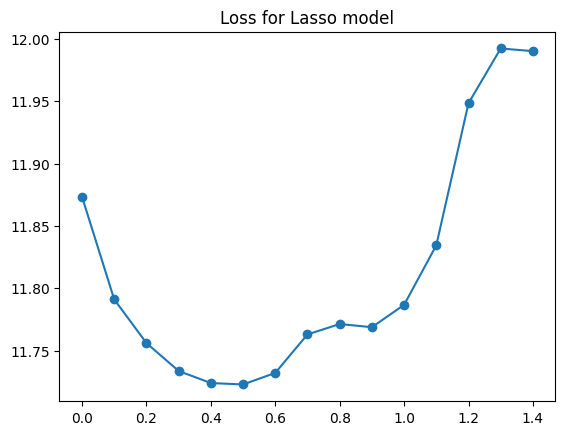

In [40]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(Lasso_alpha_list,loss_Lasso_tot)
ax.plot(Lasso_alpha_list,loss_Lasso_tot) 
plt.title("Loss for Lasso model")
plt.show()

In [41]:
model_Lasso=Lasso(alpha=0.1*np.argmin(np.array(loss_Lasso_tot)))

In [44]:
loss_Lasso=model_result(model_Lasso,X_train_vec,y_train_vec,X_test_vec,y_test_vec)
loss_Lasso

11.722754282377979

In [45]:
loss_Lasso_num=model_result(model_Lasso,X_train_num_vec,y_train_vec,X_test_num_vec,y_test_vec)
loss_Lasso_num

11.728216138844159

In [50]:
alpha_list_Knn=[(i+1) for i in range(6,14)]
loss_Knn_tot=[]
for alpha in alpha_list_Knn:    
    model_Knn=KNeighborsRegressor(n_neighbors=alpha)
    loss_Knn=model_result(model_Knn,X_train_vec,y_train_vec,X_test_vec,y_test_vec)
    loss_Knn_tot.append(loss_Knn)
    print("loss="+str(loss_Knn)+"; param={:2f}".format(alpha))

loss=10.002439001421966; param=7.000000
loss=9.976645855110132; param=8.000000
loss=9.879330640073077; param=9.000000
loss=9.84488327636052; param=10.000000
loss=9.838969404186795; param=11.000000
loss=9.843508395250069; param=12.000000
loss=9.842472525920275; param=13.000000
loss=9.86856701603714; param=14.000000


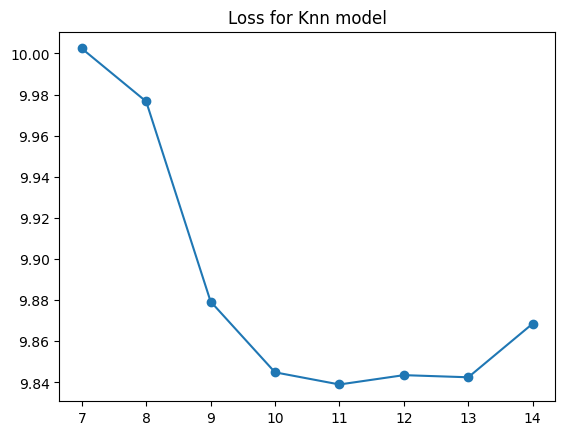

In [51]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(alpha_list_Knn,loss_Knn_tot)
ax.plot(alpha_list_Knn,loss_Knn_tot) 
plt.title("Loss for Knn model")
plt.show()

In [52]:
model_Knn=KNeighborsRegressor(n_neighbors=1+np.argmin(np.array(loss_Knn_tot)))

In [53]:
loss_Knn=model_result(model_Knn,X_train_vec,y_train_vec,X_test_vec,y_test_vec)

In [54]:
loss_Knn

10.138881826143459

In [55]:
loss_Knn_num=model_result(model_Knn,X_train_num_vec,y_train_vec,X_test_num_vec,y_test_vec)
loss_Knn_num

9.084602273262329

In [56]:
alpha_list_RF=[i for i in range(10,20)]
loss_RF_tot=[]
for alpha in alpha_list_RF:    
    model_RF=RandomForestRegressor(max_depth=alpha)
    loss_RF=model_result(model_RF,X_train_vec,y_train_vec,X_test_vec,y_test_vec)
    loss_RF_tot.append(loss_RF)
    print("loss="+str(loss_RF)+"; param={:2f}".format(alpha))

loss=8.288169430554378; param=10.000000
loss=8.244747671648257; param=11.000000
loss=8.25484268911678; param=12.000000
loss=8.196965844563099; param=13.000000
loss=8.105300825870366; param=14.000000
loss=8.152188038534339; param=15.000000
loss=8.152847228107843; param=16.000000
loss=8.172943093105818; param=17.000000
loss=8.180269514365625; param=18.000000
loss=8.138834741173923; param=19.000000


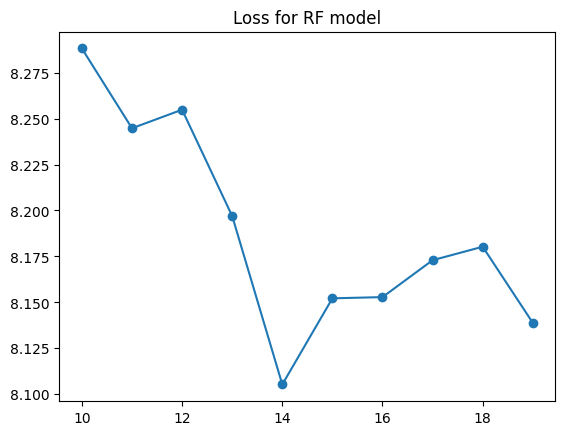

In [57]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(alpha_list_RF,loss_RF_tot)
ax.plot(alpha_list_RF,loss_RF_tot) 
plt.title("Loss for RF model")
plt.show()

In [58]:
model_RF=RandomForestRegressor(max_depth=np.argmin(np.array(loss_Knn_tot)))

In [59]:
loss_RF=model_result(model_RF,X_train_vec,y_train_vec,X_test_vec,y_test_vec)
loss_RF

8.04710380352384

In [60]:
loss_RF_num=model_result(model_RF,X_train_num_vec,y_train_vec,X_test_num_vec,y_test_vec)
loss_RF_num

8.31815313915492

In [61]:
alpha_list_LogR=[1.0+0.1*i for i in range(5,14)]
loss_LogR_tot=[]
for alpha in alpha_list_LogR:    
    model_LogR=LogisticRegression(C=alpha)
    loss_LogR=model_result(model_LogR,X_train_vec,y_train_vec,X_test_vec,y_test_vec)
    loss_LogR_tot.append(loss_LogR)
    print("loss="+str(loss_LogR)+"; param={:2f}".format(alpha))

loss=13.502923976608187; param=1.500000
loss=13.316147319452684; param=1.600000
loss=13.88214632125133; param=1.700000
loss=13.976043167500071; param=1.800000
loss=13.532257912629131; param=1.900000
loss=13.800180806283018; param=2.000000
loss=13.330743660008851; param=2.100000
loss=13.380126376058234; param=2.200000
loss=13.3155163808609; param=2.300000


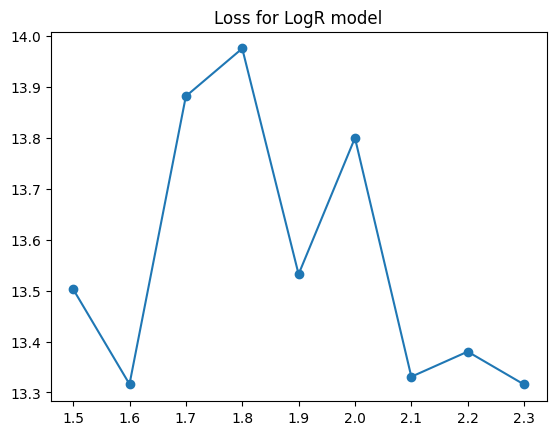

In [62]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(alpha_list_LogR,loss_LogR_tot)
ax.plot(alpha_list_LogR,loss_LogR_tot) 
plt.title("Loss for LogR model")
plt.show()

In [63]:
model_LogR=LogisticRegression(C=1+0.1*np.argmin(np.array(loss_Knn_tot)))

In [64]:
loss_LogR=model_result(model_LogR,X_train_vec,y_train_vec,X_test_vec,y_test_vec)
loss_LogR

13.880827942104322

In [65]:
loss_LogR_num=model_result(model_LogR,X_train_num_vec,y_train_vec,X_test_num_vec,y_test_vec)
loss_LogR_num

13.872371481575652

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
dataset_tot_XY = torch.utils.data.TensorDataset(X_train_num_tensor.to(device),train_text_tensor.to(device),train_tags_tensor.to(device), y_train_tensor.to(device))
testset_tot_XY = torch.utils.data.TensorDataset(X_test_num_tensor.to(device),test_text_tensor.to(device),test_tags_tensor.to(device), y_test_tensor.to(device))

In [113]:
class RegressionNet_lstm(torch.nn.Module):
    def __init__(self, numeric, text_length,tag_length, hidden_size, num_layers, batch_size, fc1, fc2):
        super(RegressionNet_lstm, self).__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.numeric=numeric
        
        self.lstm_text=torch.nn.LSTM(text_length,hidden_size,num_layers,batch_first=True)  
        self.lstm_tag=torch.nn.LSTM(tag_length,hidden_size,num_layers,batch_first=True) 
        
        self.fc_layer1=torch.nn.Linear(hidden_size+numeric, fc1)
        self.fc_layer2=torch.nn.Linear(fc1, fc2)
        self.fc_layer3=torch.nn.Linear(fc2, 1)
        
        self.dropout=torch.nn.Dropout(p=0.5)
    def forward(self, x_num, x_text, x_tag):
        # x_num=x_num.flatten()
        h0_text=torch.zeros(self.num_layers,x_text.size(0),self.hidden_size).to(device)
        c0_text=torch.zeros(self.num_layers,x_text.size(0),self.hidden_size).to(device)        
        out_text,_=self.lstm_text(x_text,(h0_text,c0_text))
        out_text=self.dropout(out_text)
        out_text=out_text[0]
        
        h0_tag=torch.zeros(self.num_layers,x_tag.size(0),self.hidden_size).to(device)
        c0_tag=torch.zeros(self.num_layers,x_tag.size(0),self.hidden_size).to(device)        
        out_tag,_=self.lstm_tag(x_tag,(h0_tag,c0_tag))
        out_tag=self.dropout(out_tag)
        out_tag=out_tag[0]
        
        out_non_num=out_text+out_tag
        
#         print(x_num.shape)
#         print(out_non_num.shape)
        
        out=torch.cat((x_num,out_non_num), axis=1)
        out=self.fc_layer1(out)
        out = self.dropout(out)
        out=F.relu(out)
        out=self.fc_layer2(out)
        out = self.dropout(out)
        out=F.relu(out)
        out=self.fc_layer3(out)
        # x_tot=x_tot.int()
        out=F.relu(out)
        
        
        return out

In [137]:
def trainer(data_train,data_test,model,loss_fn,epoch=100,batch_size=16,rate=1e-3,train_record=[],eval_record=[],eval_interval=10):
    optimiser=torch.optim.Adam(model.parameters(),lr=rate)
    loader_train=torch.utils.data.DataLoader(dataset=data_train,batch_size=batch_size,shuffle=True)
    loader_test=torch.utils.data.DataLoader(dataset=data_test,batch_size=batch_size,shuffle=True)
    for i in range(epoch):
        loss_epoch=0
        loss_total=0
        print("---------------------- now training epoch "+str(i)+" ----------------------")
        for step,(batch_x_num,batch_x_text,batch_x_tag,batch_y) in enumerate(loader_train):    
            #print(batch_x.float())            
            batch_x_num=batch_x_num.to(device)
            
            batch_x_text=batch_x_text.reshape((-1,batch_x_text.shape[0],batch_x_text.shape[1]))
            batch_x_text=batch_x_text.to(device)
            
            batch_x_tag=batch_x_tag.reshape((-1,batch_x_tag.shape[0],batch_x_tag.shape[1]))
            batch_x_tag=batch_x_tag.to(device)
            
            batch_y=batch_y.to(device)
            
            pred=model(batch_x_num,batch_x_text,batch_x_tag)
                        
            loss=loss_fn(pred,batch_y)  

            loss_total+=loss
            train_loss=float(loss_total/(step+1))
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

        train_record.append(train_loss)
        print("training epoch "+str(i)+" loss "+str(train_loss))
                
        if i % (eval_interval)==0:
            loss_total_test=0
            test_loss=0
            print("---------------------- epoch "+str(i)+" now evaluating ------------------------")
            for step,(batch_x_num,batch_x_text,batch_x_tag,batch_y) in enumerate(loader_test):    
            #print(batch_x.float())
                batch_x_num=batch_x_num.to(device)
            
                batch_x_text=batch_x_text.reshape((-1,batch_x_text.shape[0],batch_x_text.shape[1]))
                batch_x_text=batch_x_text.to(device)
            
                batch_x_tag=batch_x_tag.reshape((-1,batch_x_tag.shape[0],batch_x_tag.shape[1]))
                batch_x_tag=batch_x_tag.to(device)
            
                batch_y=batch_y.to(device)
                
                pred=model(batch_x_num,batch_x_text,batch_x_tag)
            #class_pred = torch.argmax(pred,dim = -1)
                loss=loss_fn(pred,batch_y)  
                loss_total_test+=loss
                test_loss=float(loss_total_test/(step+1))
        # 应该要把预测结果都变成int的，但这样可能产生预测结果全是0，求不了梯度不能反向传播了，要想个办法
            eval_record.append(test_loss)
            
            print("evaluation epoch "+str(i)+" loss "+str(test_loss))
        

In [138]:
batch_size=16

In [139]:
RNet=RegressionNet_lstm(X_train_num_tensor.shape[1],train_text_tensor.shape[1],train_tags_tensor.shape[1],20,5,batch_size,100,30).to(device)

In [140]:
train_record=[]
eval_record=[]

In [ ]:
trainer(dataset_tot_XY,testset_tot_XY,RNet,torch.nn.L1Loss(),epoch=120,batch_size=batch_size,rate=1e-4,train_record=train_record,eval_record=eval_record,eval_interval=10)

---------------------- now training epoch 0 ----------------------
---------------------- epoch 0 now evaluating ------------------------
epoch 0 loss 15.597705841064453
---------------------- now training epoch 1 ----------------------
---------------------- now training epoch 2 ----------------------
---------------------- now training epoch 3 ----------------------
---------------------- now training epoch 4 ----------------------
---------------------- now training epoch 5 ----------------------
---------------------- now training epoch 6 ----------------------
---------------------- now training epoch 7 ----------------------
---------------------- now training epoch 8 ----------------------
---------------------- now training epoch 9 ----------------------
---------------------- now training epoch 10 ----------------------
---------------------- epoch 10 now evaluating ------------------------
epoch 10 loss 15.356171607971191
---------------------- now training epoch 11 ---------

In [134]:
# Load data


eval_data = pd.read_csv("data/evaluation.csv")
X_eval=pd.read_csv("data/evaluation.csv")

# Pre-process the traning data
label = "text"
eval_data[label] = eval_data[label].map(lambda x: str.split(x, sep=" "))


label = "mentions"
eval_data[label+"_count"] = eval_data[label].map(lambda x: len(str.split(x)))
mentions = set()
eval_data[label].apply(lambda x: mentions.update(x))
print("all mentions in eval data: ", mentions)


label = "urls"
eval_data[label] = eval_data[label].map(lambda x: [] if x=="[]" else [str.strip(url) for url in str.split(x[1:-1], sep=",")])
eval_data[label+"_count"] = eval_data[label].map(lambda x: len(x))
urls = set()
# hashtags=set()
eval_data[label].apply(lambda x: None if len(x)<1 else urls.update(x))
# train_data[label].apply(lambda x: None if len(x)<1 else hashtags.update(x))
print(f"average number of urls in eval data: {eval_data.urls_count.mean():1.3f}")
print("number of distinct urls in eval data: ", len(urls))

label = "verified"
print("verified users: ", eval_data["verified"].sum())


label = "hashtags"
eval_data[label] = eval_data[label].map(lambda x: [] if x=="[]" else [str.strip(tag) for tag in str.split(x[1:-1], sep=",")])
eval_data[label+"_count"] = eval_data[label].map(lambda x: len(x))
hashtags = set()
eval_data[label].apply(lambda x: None if len(x)<1 else hashtags.update(x))
print(f"average number of hashtags in eval data: {eval_data.hashtags_count.mean():1.3f}")
print("number of distinct hashtags in eval data:", len(hashtags))

# Treatment of time
# The time relative to the election (month and yday), day in the week, 
# and the hour all affect the number of retweets.
eval_data["timestamp"] = eval_data["timestamp"].map(lambda x: time.gmtime(x//1000))
# Only 2380 tweets are not posted in 2022, so we ignore the year
# train_data["year"] = train_data["timestamp"].map(lambda x: x.tm_year)
eval_data["month"] = eval_data["timestamp"].map(lambda x: x.tm_mon)
eval_data["yday"] = eval_data["timestamp"].map(lambda x: x.tm_yday)
eval_data["wday"] = eval_data["timestamp"].map(lambda x: x.tm_wday)
eval_data["hour"] = eval_data["timestamp"].map(lambda x: x.tm_hour)
print("number of tweets not posted in 2022 in eval data:", len(eval_data[eval_data["timestamp"].map(lambda x: x.tm_year) < 2022]))

# We drop the following data:
# @TweetID: useless
# @mentions: none of the mentions in the train data are not null
# @mentions_count
# @hashtags_count: we use hashtags directly
# @urls: we use urls_count instead

eval_data.drop(labels=["TweetID","timestamp", "mentions","mentions_count", "hashtags_count", "urls"], axis=1, inplace=True)
eval_data.head(5)

all mentions in eval data:  {']', '['}
average number of urls in eval data: 0.528
number of distinct urls in eval data:  62185
verified users:  3464
average number of hashtags in eval data: 0.299
number of distinct hashtags in eval data: 5942
number of tweets not posted in 2022 in eval data: 777


,text,favorites_count,followers_count,statuses_count,friends_count,verified,hashtags,urls_count,month,yday,wday,hour
0,"[descendue, pourcentage, vote]",0,85,4442,327,0,"['presidentielle2022', 'hidalgo']",0,3,77,4,12
1,"[photo, demande, arbre, généalogique]",0,427,33282,443,0,[],0,3,77,4,11
2,"[dossiers, promis, poste, gars, vraiment, fiable]",6,1127,13111,1596,0,['macron'],0,3,69,3,8
3,"[lol, cas, faut, second, tour, macron, sortir,...",2,1699,25760,2036,0,[],1,3,72,6,8
4,"[zemmour, putain, discours, propagandiste, lit...",0,249,20718,369,0,[],2,3,78,5,21


In [102]:
standardise(eval_data,["favorites_count","followers_count","statuses_count","friends_count","urls_count","month","yday","wday","hour"])

# split the table into 2 parts: one with the text and the other with the numbers
X_eval_num=eval_data.drop(["text", "hashtags"], axis=1)

X_eval_text=eval_data[["text", "hashtags"]]


In [103]:
# text to vector
eval_text_tensor=torch.Tensor(text2vec(X_eval_text["text"], model=model_text10))

# hashtags to vector
eval_tags_tensor=torch.Tensor(text2vec(X_eval_text["hashtags"], model=model_text5))

# combine the two vectors
X_eval_text_tensor = torch.cat((eval_text_tensor, eval_tags_tensor), axis=1)

In [104]:
X_eval_num_vec=X_eval_num.to_numpy()
X_eval_text_vec=X_eval_text_tensor.numpy()
X_eval_vec=np.hstack([X_eval_num_vec,X_eval_text_vec])

In [105]:
X_eval_num_tensor=torch.Tensor(X_eval_num.values)

X_eval_tensor=torch.cat((X_eval_num_tensor, X_eval_text_tensor), axis=1)

print(X_eval_num_tensor.shape)
print(X_eval_text_tensor.shape)
print(X_eval_tensor.shape)

torch.Size([117990, 10])
torch.Size([117990, 15])
torch.Size([117990, 25])


In [106]:
evalset_tot_XY = torch.utils.data.TensorDataset(X_eval_num_tensor.to(device),eval_text_tensor.to(device),eval_tags_tensor.to(device))

In [125]:
def evaluate(data_eval,model,batch_size=16):
    loader_eval=torch.utils.data.DataLoader(dataset=data_eval,batch_size=batch_size,shuffle=True)
    res=[]
    for step,(batch_x_num,batch_x_text,batch_x_tag) in enumerate(loader_eval):    
            #print(batch_x.float())            
        batch_x_num=batch_x_num.to(device)
            
        batch_x_text=batch_x_text.reshape((-1,batch_x_text.shape[0],batch_x_text.shape[1]))
        batch_x_text=batch_x_text.to(device)
            
        batch_x_tag=batch_x_tag.reshape((-1,batch_x_tag.shape[0],batch_x_tag.shape[1]))
        batch_x_tag=batch_x_tag.to(device)
            
            
        pred=model(batch_x_num,batch_x_text,batch_x_tag)                   
        
            
        for i in range(len(pred)):
            pd=round(pred[i]) if pred[i]>0 else 0                       
            res.append(pd)
            
        if (step%1000==0):
                print("now evaluating step "+str(step))
        
    return res
        

In [126]:
evaluations_lstm=evaluate(evalset_tot_XY,RNet,batch_size)

now evaluating step 0
now evaluating step 100
now evaluating step 200
now evaluating step 300
now evaluating step 400
now evaluating step 500
now evaluating step 600
now evaluating step 700
now evaluating step 800
now evaluating step 900
now evaluating step 1000
now evaluating step 1100
now evaluating step 1200
now evaluating step 1300
now evaluating step 1400
now evaluating step 1500
now evaluating step 1600
now evaluating step 1700
now evaluating step 1800
now evaluating step 1900
now evaluating step 2000
now evaluating step 2100
now evaluating step 2200
now evaluating step 2300
now evaluating step 2400
now evaluating step 2500
now evaluating step 2600
now evaluating step 2700
now evaluating step 2800
now evaluating step 2900
now evaluating step 3000
now evaluating step 3100
now evaluating step 3200
now evaluating step 3300
now evaluating step 3400
now evaluating step 3500
now evaluating step 3600
now evaluating step 3700
now evaluating step 3800
now evaluating step 3900
now evaluati

In [135]:
def write_result(filename,results):
    with open(filename, 'w',newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["TweetID", "retweets_count"])
        for index, prediction in enumerate(results):
            writer.writerow([str(X_eval['TweetID'].iloc[index]) , str(int(prediction))])

In [136]:
write_result("tabnet_predictions_0.txt",evaluations_lstm)